In [12]:
import h5py

h5filename = '/data1/public/vqhlm/wikitext103_gpt2finetuned/test.h5'

# 数据操作

## ChunkedDataset

In [13]:
from dataloading import get_chunked_h5dataloader
from constants import KEY_LM_INPUT_IDS, KEY_LM_HIDDEN_STATES, KEY_LM_LABELS

dataloader = get_chunked_h5dataloader(
    config_path='conf/data/example_normed.yaml',
    split='test',
)

for batch in dataloader:
    input_ids = batch[KEY_LM_INPUT_IDS]
    labels = batch[KEY_LM_LABELS]
    hidden_states = batch[KEY_LM_HIDDEN_STATES]
    
    print(f"Input IDs: {input_ids.shape}")
    print(f"Labels: {labels.shape}")
    print(f"Hidden States: {hidden_states.shape}")
    break  # 这里只打印一个批次的数据

Input IDs: torch.Size([128, 1024])
Labels: torch.Size([128, 1024])
Hidden States: torch.Size([128, 256, 768])


## 线性缩放计算Loss估计值

In [3]:
def calculate_dataset_stats(dataloader, ratio=0.7):
    total_loss = 0
    # 遍历整个数据集并收集所有的 hidden_states
    for i, batch in enumerate(dataloader):
        hidden_states = batch[KEY_LM_HIDDEN_STATES]
        out = ratio * hidden_states
        # out = out.clamp(-1., 1.)
        rec_loss = (out - hidden_states).abs().mean()
        total_loss += rec_loss.item()
    total_loss /= len(dataloader)
    return total_loss    

# # 示例用法：
for ratio in range(60, 100, 2):
    ratio = 0.01*ratio
    total_loss = calculate_dataset_stats(dataloader, ratio)
    print("%.2f"%(ratio), f":{total_loss}")

0.60 :0.06889273226261139
0.62 :0.06544810036818187
0.64 :0.06200346723198891
0.66 :0.05855882167816162
0.68 :0.05511418730020523
0.70 :0.05166955292224884
0.72 :0.048224907368421555
0.74 :0.04478027547399203
0.76 :0.04133564109603564
0.78 :0.03789100920160612
0.80 :0.03444636488954226
0.82 :0.031001731753349304
0.84 :0.02755709799627463
0.86 :0.024112453684210777
0.88 :0.02066782054801782
0.90 :0.017223188032706577
0.92 :0.013778544341524443
0.94 :0.01033391027400891
0.96 :0.00688927744825681
0.98 :0.0034446336018542447


## 高斯分布计算Loss估计值

In [4]:
import torch

def calculate_dataset_stats(dataloader, ratio=0.7):
    total_loss = 0
    # 遍历整个数据集并收集所有的 hidden_states
    for i, batch in enumerate(dataloader):
        hidden_states = batch[KEY_LM_HIDDEN_STATES]
        
        # 创建一个形状为 (256,) 的掩码，标记出比例为 (1-ratio) 的部分
        mask = torch.rand(hidden_states.size(1)) < ratio  # mask的大小是 (256,)
        
        # 扩展掩码到 (128, 256, 768) 形状
        mask = mask.unsqueeze(0).unsqueeze(2).expand(hidden_states.size(0), hidden_states.size(1), hidden_states.size(2))
        
        # 生成一个形状与 hidden_states 相同的高斯分布张量
        gaussian_fill = torch.normal(mean=hidden_states.mean(), std=hidden_states.std())  # 生成均值为0，方差为1的高斯分布
        # gaussian_fill = torch.randn_like(hidden_states)  # 生成均值为0，方差为1的高斯分布
        
        # 将被掩盖为零的部分用高斯分布填充
        masked_hidden_states = hidden_states * mask.float() + gaussian_fill * (1 - mask.float())
        
        # 计算重构损失
        rec_loss = (masked_hidden_states - hidden_states).abs().mean()
        total_loss += rec_loss.item()

    total_loss /= len(dataloader)
    return total_loss

for ratio in range(60, 100, 2):
    ratio = 0.01*ratio
    total_loss = calculate_dataset_stats(dataloader, ratio)
    print("%.2f"%(ratio), f":{total_loss}")

0.60 :0.13921922693649927
0.62 :0.15107508997122446
0.64 :0.20478572199741998
0.66 :0.09635759145021439
0.68 :0.06801183770100276
0.70 :0.0702599361538887
0.72 :0.06766711547970772
0.74 :0.06093065689007441
0.76 :0.050541323920090996
0.78 :0.03876931220293045
0.80 :0.054274054865042366
0.82 :0.032897524535655975
0.84 :0.04510338852802912
0.86 :0.04189051377276579
0.88 :0.031099339947104454
0.90 :0.026102940862377483
0.92 :0.0128426942974329
0.94 :0.018153051535288494
0.96 :0.01909277184555928
0.98 :0.004780377882222335


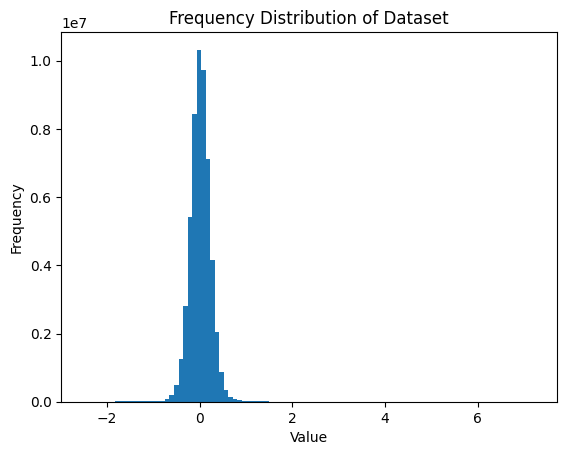

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# 假设你的 dataloader 是这样的
# dataloader = ...

# 频率分布的边界：你可以根据数据范围来选择适当的区间
bins = 100  # 可以根据数据的范围调整
min_value, max_value = float('inf'), float('-inf')

# 首先遍历数据集，获取最小和最大值
for batch in dataloader:
    min_value = min(min_value, batch[KEY_LM_HIDDEN_STATES].min().item())
    max_value = max(max_value, batch[KEY_LM_HIDDEN_STATES].max().item())

# 创建一个全局的计数器
hist_counts = np.zeros(bins)

# 遍历数据集，按批次更新频率分布
for batch in dataloader:
    # 扁平化数据并转为 numpy
    batch_data = batch[KEY_LM_HIDDEN_STATES].view(-1).cpu().numpy()
    
    # 使用 numpy 计算当前批次的频率分布
    hist, bin_edges = np.histogram(batch_data, bins=bins, range=(min_value, max_value))
    
    # 更新全局频率计数器
    hist_counts += hist

# 绘制最终的频率分布图
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])  # 获取每个 bin 的中心
plt.bar(bin_centers, hist_counts, width=(bin_edges[1] - bin_edges[0]), align='center')
plt.title('Frequency Distribution of Dataset')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

## H5py直接操作

- 模型来自 https://huggingface.co/neulab/gpt2-finetuned-wikitext103
- 模型tokenizer和定义如下
```
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("neulab/gpt2-finetuned-wikitext103")
model = AutoModelForCausalLM.from_pretrained("neulab/gpt2-finetuned-wikitext103")
```

In [15]:
# 读取 HDF5 文件
with h5py.File(h5filename, 'r') as f:
    # 读取 total_samples 元数据
    total_samples = f.attrs['total_samples']
    print(f"Total samples in the dataset: {total_samples}")
    
    # 读取数据集
    hidden_states = f['hidden_states'][:]
    input_ids = f['input_ids'][:]
    labels = f['labels'][:]

    # 打印数据集的形状，确保读取正确
    print(f"Hidden states shape: {hidden_states.shape}")
    print(f"Input IDs shape: {input_ids.shape}")
    print(f"Labels shape: {labels.shape}")
    
    # 获取第一个样本的数据并展示
    sample_idx = 0  # 举例，读取第一个样本
    print(f"Sample {sample_idx} - Input IDs: {input_ids[sample_idx]}")
    print(f"Sample {sample_idx} - Labels: {labels[sample_idx]}")
    
    # 获取对应的 hidden states (flattened)
    print(f"Sample {sample_idx} - Hidden States: {hidden_states[sample_idx]}")

Total samples in the dataset: 548
Hidden states shape: (548, 1024, 768)
Input IDs shape: (548, 1024)
Labels shape: (548, 1024)
Sample 0 - Input IDs: [  796  5199   347 ... 50256 50256 50256]
Sample 0 - Labels: [ 796 5199  347 ... -100 -100 -100]
Sample 0 - Hidden States: [[-1.6174933  -1.1284641   0.0215988  ... -2.2583933   1.6741287
  -0.35499385]
 [-5.498198    2.3329258  -2.2865224  ...  0.42031875  0.07713613
   1.1435596 ]
 [ 1.8659987   1.5455958   1.0896978  ...  3.514292   -0.08421862
   3.3854916 ]
 ...
 [ 0.798916    2.5979886  -0.07587534 ... -0.737859   -1.1983643
   4.190173  ]
 [ 0.7338563   2.760131   -0.01490831 ... -0.6301186  -1.1114419
   4.6592402 ]
 [ 0.7557825   1.4493941  -3.1341372  ... -2.043258    0.9624741
   5.8210287 ]]
